In [3]:
%%javascript
var width = window.innerWidth || document.documentElement.clientWidth || document.body.clientWidth;
var height = window.innerHeight || document.documentElement.clientHeight || document.body.clientHeight;

IPython.notebook.kernel.execute("windowSize = (" + width + "," + height + ")");
// suitable for small screens
nbpresent.mode.tree.set(
    ["app", "theme-manager", "themes", "my-theme"], 
    {
    palette: {
        "blue": { id: "blue", rgb: [0, 153, 204] },
        "black": { id: "black", rgb: [0, 0, 0] },
        "white": { id: "white", rgb: [255, 255, 255] },
        "red": { id: "red", rgb: [240, 32, 32] },
        "gray": { id: "gray", rgb: [128, 128, 128] },
    },
    backgrounds: {
        "my-background": {
            "background-color": "white"
        }
    },
    "text-base": {
        "font-family": "Georgia",
        "font-size": 2.5
    },
    rules: {
        h1: {
            "font-size": 5.5,
            color: "blue",
            "text-align": "center"
        },
        h2: {
            "font-size": 3,
            color: "blue",
            "text-align": "center"
        },
        h3: {
            "font-size": 3,
            color: "black",
        },
        "ul li": {
            "font-size": 2.5,
            color: "black"
        },
        "ul li ul li": {
            "font-size": 2.0,
            color: "black"
        },
        "code": {
            "font-size": 1.6,
        },
        "pre": {
            "font-size": 1.6,
        }
    }
});

<IPython.core.display.Javascript object>


# Scaling Up Peptide Sequencing

<img src="http://csbio.unc.edu/mcmillan/Comp555S18/Media/Scaling.png" width="500px" class="centerImg">

* More Errors
* More Residues

<p style="text-align: right; clear: right; margin-right: 200px;">1</p>

# From Last Time

In [2]:
AminoAcid = {
    'A': 'Alanine', 'C': 'Cysteine', 'D': 'Aspartic acid', 'E': 'Glutamic acid',
    'F': 'Phenylalanine', 'G': 'Glycine', 'H': 'Histidine', 'I': 'Isoleucine',
    'K': 'Lysine', 'L': 'Leucine', 'M': 'Methionine', 'N': 'Asparagine',
    'P': 'Proline', 'Q': 'Glutamine', 'R': 'Arginine', 'S': 'Serine',
    'T': 'Theronine', 'V': 'Valine', 'W': 'Tryptophan', 'Y': 'Tyrosine',
    '*': 'STOP'
}

AminoAbbrv = {
    'A': 'Ala', 'C': 'Cys', 'D': 'Asp', 'E': 'Glu',
    'F': 'Phe', 'G': 'Gly', 'H': 'His', 'I': 'Ile',
    'K': 'Lys', 'L': 'Leu', 'M': 'Met', 'N': 'Asn',
    'P': 'Pro', 'Q': 'Gln', 'R': 'Arg', 'S': 'Ser',
    'T': 'Thr', 'V': 'Val', 'W': 'Trp', 'Y': 'Tyr',
    '*': 'STP'    
}

# Now it's time to use this dictionary!
Daltons = { 
    'A':  71, 'C': 103, 'D': 115, 'E': 129,
    'F': 147, 'G':  57, 'H': 137, 'I': 113,
    'K': 128, 'L': 113, 'M': 131, 'N': 114,
    'P':  97, 'Q': 128, 'R': 156, 'S':  87,
    'T': 101, 'V':  99, 'W': 186, 'Y': 163 
}

def TheoreticalSpectrum(peptide):
    # Generate every possible fragment of a peptide
    spectrum = set()
    for fragLength in xrange(1,len(peptide)+1):
        for start in xrange(0,len(peptide)-fragLength+1):
            seq = peptide[start:start+fragLength]
            spectrum.add(sum([Daltons[res] for res in seq]))
    return sorted(spectrum)

<p style="text-align: right; clear: right; margin-right: 200px;">2</p>

# Recall our golf tourney approach

In [14]:
import itertools

def LeaderboardFindPeptide(noisySpectrum, cutThreshold=0.05):
    # Golf Tournament Heuristic
    spectrum = set(noisySpectrum)
    target = max(noisySpectrum)
    players = [''.join(peptide) for peptide in itertools.product(Daltons.keys(), repeat=2)]
    round = 1
    currentLeader = [0.0, '']
    while True:
        print "%8d Players in round %d [%5.4f]" % (len(players), round, currentLeader[0])
        leaderboard = []
        for prefix in players:
            testSpectrum = set(TheoreticalSpectrum(prefix))
            totalWeight = max(testSpectrum)
            score = len(spectrum & testSpectrum)/float(len(spectrum | testSpectrum))
            if (score > currentLeader[0]):
                currentLeader = [score, prefix]
            elif (score == currentLeader[0]):
                currentLeader += [prefix]
            if (totalWeight < target):
                leaderboard.append((score, prefix))
        remaining = len(leaderboard)
        if (remaining == 0):
            print "Done, no sequences can be extended"
            break
        leaderboard.sort(reverse=True)
        # Prune the larger of the top 5% or the top 5 players
        cut = leaderboard[max(min(5,remaining-1),int(remaining*cutThreshold))][0]
        players = [p+r for s, p in leaderboard if s >= cut for r in Daltons.iterkeys()]
        round += 1
    return currentLeader

<p style="text-align: right; clear: right; margin-right: 200px;">3</p>

# Let's try a Noisier Spectrum

In [15]:
# generate a synthetic experimental spectrum with 60% Error
import random
random.seed(1961)

TyrocidineB1 = "VKLFPWFNQY"
print TyrocidineB1
spectrum = TheoreticalSpectrum(TyrocidineB1)
print len(spectrum), spectrum

# Pick around ~60% at random to remove
missingMass = random.sample(spectrum[:-1], 30)
print "\nMissing Masses = %s\n" % missingMass

# Add back another ~10% of false, but actual, peptide masses
falseMass = []
for i in xrange(5):
    fragment = ''.join(random.sample(Daltons.keys(), random.randint(2,len(TyrocidineB1)-2)))
    weight = sum([Daltons[residue] for residue in fragment])
    falseMass.append(weight)
print "False Masses = ", falseMass

experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingMass] + falseMass))

print len(experimentalSpectrum), experimentalSpectrum

VKLFPWFNQY
51 [97, 99, 113, 114, 128, 147, 163, 186, 227, 241, 242, 244, 260, 261, 283, 291, 333, 340, 357, 388, 389, 405, 430, 447, 485, 487, 543, 544, 552, 575, 577, 584, 671, 672, 690, 691, 738, 770, 804, 818, 819, 835, 917, 932, 982, 1031, 1060, 1095, 1159, 1223, 1322]

Missing Masses = [1159, 114, 691, 186, 819, 357, 291, 543, 1223, 147, 671, 97, 388, 552, 447, 770, 672, 261, 738, 487, 577, 485, 932, 1031, 690, 389, 340, 575, 113, 260]

False Masses =  [356, 160, 572, 879, 244]
25 [99, 128, 160, 163, 227, 241, 242, 244, 283, 333, 356, 405, 430, 544, 572, 584, 804, 818, 835, 879, 917, 982, 1060, 1095, 1322]


<p style="text-align: right; clear: right; margin-right: 200px;">4</p>

# Find peptides via the leaderboard approach

In [16]:
spectrum = TheoreticalSpectrum(TyrocidineB1)
experimentalSpectrum = [mass for mass in spectrum if mass not in missingMass] + falseMass
%time winners = LeaderboardFindPeptide(experimentalSpectrum)
print winners
print len(winners) - 1, "Candidate residues with", winners[0], 'matches'
print TyrocidineB1, TyrocidineB1 in winners

     400 Players in round 1 [0.0000]
     440 Players in round 2 [0.1200]
     600 Players in round 3 [0.1481]
    1480 Players in round 4 [0.2069]
    1840 Players in round 5 [0.2121]
    2320 Players in round 6 [0.2222]
    5200 Players in round 7 [0.2619]
    5360 Players in round 8 [0.2826]
    8640 Players in round 9 [0.2826]
    9040 Players in round 10 [0.3220]
    8320 Players in round 11 [0.3220]
     480 Players in round 12 [0.3220]
Done, no sequences can be extended
CPU times: user 3.91 s, sys: 56 ms, total: 3.97 s
Wall time: 3.9 s
[0.3220338983050847, 'VQLDEWFNQY', 'VQLDEWFNKY', 'VQIDEWFNQY', 'VQIDEWFNKY', 'VKLDEWFNQY', 'VKLDEWFNKY', 'VKIDEWFNQY', 'VKIDEWFNKY']
8 Candidate residues with 0.322033898305 matches
VKLFPWFNQY False


<p style="text-align: right; clear: right; margin-right: 200px;">5</p>

# Let's try the example in the book

The example on page 66 of the book gives a different answer using our method, because the book does not *normalize*
it's similarity metric. While 'VKLFPADFNQY' has one more match, 'VKLFPWFNQY' it also adds 10 unmatched peaks. 

In [17]:
missingBook = [357,430,543,671,747,778,1031,1061,1225]
falseBook = [115,256,309,330,347,385,435,599,608,653,717,827]
spectrum = TheoreticalSpectrum(TyrocidineB1)
experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingBook] + falseBook))
%time winners = LeaderboardFindPeptide(experimentalSpectrum)
print winners
print len(winners) - 1, "Candidate residues with", winners[0], 'matches'
print TyrocidineB1, TyrocidineB1 in winners
print
x = set(TheoreticalSpectrum('VKLFPADFNQY'))
y = set(TheoreticalSpectrum('VKLFPWFNQY'))
z = set(experimentalSpectrum)
print "%s Matches = %d, Union = %d" % ('VKLFPADFNQY', len(x & z), len(x | z))
print "%s Matches = %d, Union = %d" % ('VKLFPWFNQY', len(y & z), len(y | z))

     400 Players in round 1 [0.0000]
     760 Players in round 2 [0.0517]
    2680 Players in round 3 [0.1034]
    3800 Players in round 4 [0.1724]
    6000 Players in round 5 [0.2586]
    7320 Players in round 6 [0.3390]
    9160 Players in round 7 [0.4237]
   11280 Players in round 8 [0.5082]
   11440 Players in round 9 [0.5968]
    7840 Players in round 10 [0.7302]
     800 Players in round 11 [0.7302]
Done, no sequences can be extended
CPU times: user 4.42 s, sys: 100 ms, total: 4.52 s
Wall time: 4.4 s
[0.7301587301587301, 'YQNFWPFLQV', 'YQNFWPFLKV', 'YQNFWPFIQV', 'YQNFWPFIKV', 'YKNFWPFLQV', 'YKNFWPFLKV', 'YKNFWPFIQV', 'YKNFWPFIKV', 'VQLFPWFNQY', 'VQLFPWFNKY', 'VQIFPWFNQY', 'VQIFPWFNKY', 'VKLFPWFNQY', 'VKLFPWFNKY', 'VKIFPWFNQY', 'VKIFPWFNKY']
16 Candidate residues with 0.730158730159 matches
VKLFPWFNQY True

VKLFPADFNQY Matches = 47, Union = 73
VKLFPWFNQY Matches = 46, Union = 63


<p style="text-align: right; clear: right; margin-right: 200px;">6</p>

# A New Idea

* Maybe we are ***still*** not using our spectrum to its fullest extent
* Is there some information about *missing masses* that we can extract?

<img src="http://csbio.unc.edu/mcmillan/Comp555S18/Media/SBConfusedAtCompter.png" width="450px" class="centerImg">

<p style="text-align: right; clear: right; margin-right: 200px;">7</p>

# Information in the Mass Differences

* Recall the *theoretical spectrum* of "PLAY" is [71, 97, 113, 163, 184, 210, 234, 281, 347, 444]
* Suppose we remove masses 71 and 163, can we get them back?
* Let's generate a table of all pair-wise differences between the observed peaks
* Notice that *interesting* numbers, (***71***, *97*, *113*, 137, ***163***, *234*) are repeated in the table

|       |  97| 113| 184| 210| 234| 281| 347| 444|
|:-----:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|** 97**|    |  16|  87| <span style="color: #c0c;">113</span>| <span style="color: #0c0;">137</span>| 184| 250| 347|
|**113**|    |    |  <span style="color: #00f;">71</span>|  <span style="color: #c00;">97</span>| 121| 168| <span style="color: #0ac;">234</span>| 331|
|**184**|    |    |    |  26|  50|  <span style="color: #c00;">97</span>| <span style="color: #a80;">163</span>| 260|
|**210**|    |    |    |    |  24|  <span style="color: #00f;">71</span>| <span style="color: #0c0;">137</span>| <span style="color: #0ac;">234</span>|
|**234**|    |    |    |    |    |  47| <span style="color: #c0c;">113</span>| 210|
|**281**|    |    |    |    |    |    |  66| <span style="color: #a80;">163</span>|
|**347**|    |    |    |    |    |    |    |  <span style="color: #c00;">97</span>|

* Why does this work?
* This table of differences is called a *Spectral Convolution*

<p style="text-align: right; clear: right; margin-right: 200px;">8</p>

# Spectral Convolution

* Spectral Convolution gives us an approach for recovering some missing masses
* Given a noisy experimental spectrum
  1. Compute its spectral convolution
  2. Add frequent masses above some threshold to the spectrum
  3. Infer the peptide sequence

In [11]:
def SpectralConvolution(spectrum):
    delta = {}
    for i in xrange(len(spectrum)-1):
        for j in xrange(i+1,len(spectrum)):
            diff = abs(spectrum[j] - spectrum[i])
            delta[diff] = delta.get(diff, 0) + 1
    return delta

spectrum = TheoreticalSpectrum(TyrocidineB1)
print sorted(missingMass)
experimentalSpectrum = sorted(set([mass for mass in spectrum if mass not in missingMass] + falseMass))
specConv = SpectralConvolution(sorted(experimentalSpectrum))
N = 0
for delta, count in sorted(specConv.iteritems()):
    if (count >= 2) and (delta not in experimentalSpectrum) and (delta > min(Daltons.values())):
        print delta, "appears", count, "times*\t" if delta in missingMass else "times\t",
        experimentalSpectrum.append(delta)
        N += 1
        if (N % 4 == 0):
            print
print

[97, 113, 114, 147, 186, 260, 261, 291, 340, 357, 388, 389, 447, 485, 487, 543, 552, 575, 577, 671, 672, 690, 691, 738, 770, 819, 932, 1031, 1159, 1223]
61 appears 2 times	64 appears 2 times	78 appears 2 times	81 appears 2 times	
82 appears 2 times	113 appears 3 times*	114 appears 3 times*	142 appears 2 times	
143 appears 2 times	147 appears 2 times*	164 appears 2 times	178 appears 3 times	
188 appears 2 times	216 appears 2 times	228 appears 2 times	234 appears 2 times	
251 appears 2 times	260 appears 2 times*	277 appears 2 times	291 appears 2 times*	
302 appears 2 times	331 appears 2 times	340 appears 2 times*	345 appears 2 times	
485 appears 2 times*	487 appears 2 times*	523 appears 2 times	552 appears 2 times*	
577 appears 3 times*	591 appears 2 times	655 appears 2 times	675 appears 2 times	
676 appears 2 times	690 appears 3 times*	719 appears 2 times	738 appears 2 times*	
819 appears 2 times*	854 appears 2 times	932 appears 2 times*	


<p style="text-align: right; clear: right; margin-right: 200px;">9</p>

# Noisey spectrum enhanced by spectral convolution

In [18]:
winners = LeaderboardFindPeptide(experimentalSpectrum)
print winners
print len(winners) - 1, "Candidate residues with", winners[0], 'matches'
print TyrocidineB1, TyrocidineB1 in winners

     400 Players in round 1 [0.0000]
     760 Players in round 2 [0.0517]
    2680 Players in round 3 [0.1034]
    3800 Players in round 4 [0.1724]
    6000 Players in round 5 [0.2586]
    7320 Players in round 6 [0.3390]
    9160 Players in round 7 [0.4237]
   11280 Players in round 8 [0.5082]
   11440 Players in round 9 [0.5968]
    7840 Players in round 10 [0.7302]
     800 Players in round 11 [0.7302]
Done, no sequences can be extended
[0.7301587301587301, 'YQNFWPFLQV', 'YQNFWPFLKV', 'YQNFWPFIQV', 'YQNFWPFIKV', 'YKNFWPFLQV', 'YKNFWPFLKV', 'YKNFWPFIQV', 'YKNFWPFIKV', 'VQLFPWFNQY', 'VQLFPWFNKY', 'VQIFPWFNQY', 'VQIFPWFNKY', 'VKLFPWFNQY', 'VKLFPWFNKY', 'VKIFPWFNQY', 'VKIFPWFNKY']
16 Candidate residues with 0.730158730159 matches
VKLFPWFNQY True


<p style="text-align: right; clear: right; margin-right: 200px;">10</p>

# Some sanity checks

In [34]:
x = set(TheoreticalSpectrum('VKLFPAYVNQY'))
y = set(TheoreticalSpectrum('VKLFPWFNQY'))
z = set(experimentalSpectrum)
print "%s Matches = %d, Union = %d" % ('VKLFPAYVNQY', len(x & z), len(x | z))
print "%s Matches = %d, Union = %d" % ('VKLFPWFNQY', len(y & z), len(y | z))
print
print TheoreticalSpectrum('AYV')
print
print experimentalSpectrum
print
print TheoreticalSpectrum(TyrocidineB1)


VKLFPAYVNQY Matches = 38, Union = 86
VKLFPWFNQY Matches = 35, Union = 80

[71, 99, 163, 234, 262, 333]

[99, 128, 160, 163, 227, 241, 242, 244, 283, 333, 356, 405, 430, 544, 572, 584, 804, 818, 835, 879, 917, 982, 1060, 1095, 1322, 61, 64, 78, 81, 82, 113, 114, 142, 143, 147, 164, 178, 188, 216, 228, 234, 251, 260, 277, 291, 302, 331, 340, 345, 485, 487, 523, 552, 577, 591, 655, 675, 676, 690, 719, 738, 819, 854, 932]

[97, 99, 113, 114, 128, 147, 163, 186, 227, 241, 242, 244, 260, 261, 283, 291, 333, 340, 357, 388, 389, 405, 430, 447, 485, 487, 543, 544, 552, 575, 577, 584, 671, 672, 690, 691, 738, 770, 804, 818, 819, 835, 917, 932, 982, 1031, 1060, 1095, 1159, 1223, 1322]


<p style="text-align: right; clear: right; margin-right: 200px;">11</p>

# A More *Realistic* Example

For long sequences the underlying exponential growth becomes more evident.

In [19]:
Insulin = "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
spectrum = TheoreticalSpectrum(Insulin)
print len(spectrum)
missingMass = random.sample(spectrum[:-1], 100)
experimentalSpectrum = sorted([mass for mass in spectrum if mass not in missingMass])
print len(experimentalSpectrum)

# See slide for the following *hack*
del Daltons['I']
del Daltons['K']

%time winners = LeaderboardFindPeptide(experimentalSpectrum, cutThreshold=0.01)
print winners
print len(winners) - 1, "Candidate residues with", winners[0], 'matches'
print Insulin, Insulin in winners

# See slide for the following *hack*
Daltons['I'] = Daltons['L']
Daltons['K'] = Daltons['Q']

3407
3307
     324 Players in round 1 [0.0000]
    3060 Players in round 2 [0.0009]
   16344 Players in round 3 [0.0018]
   55548 Players in round 4 [0.0030]
  110304 Players in round 5 [0.0045]
  111492 Players in round 6 [0.0064]
   54756 Players in round 7 [0.0085]
   12528 Players in round 8 [0.0109]
    8694 Players in round 9 [0.0136]
    4176 Players in round 10 [0.0166]
     972 Players in round 11 [0.0193]
     234 Players in round 12 [0.0224]
     180 Players in round 13 [0.0257]
     180 Players in round 14 [0.0290]
     108 Players in round 15 [0.0320]
     108 Players in round 16 [0.0356]
     108 Players in round 17 [0.0394]
     126 Players in round 18 [0.0430]
     108 Players in round 19 [0.0472]
     108 Players in round 20 [0.0514]
     126 Players in round 21 [0.0561]
     108 Players in round 22 [0.0602]
     126 Players in round 23 [0.0648]
     108 Players in round 24 [0.0696]
     108 Players in round 25 [0.0743]
     108 Players in round 26 [0.0789]
     108 Pl

Some of the reasons that things blow up:
  1. The search space got large fast
  2. There must be a *LOT* of ties
  3. Algorithm tends to keep all (N-k+1) subpeptides as k approaches the sequence's size (k is related to our *round*)
  3. The I/L and K/Q ambiguities lead to exponential number of ties, hence the *hack*
  4. Reversed sequences are doubling our leaderboard size

There are bandaids to fix problems 3 and 4, but the problem remains

<p style="text-align: right; clear: right; margin-right: 200px;">12</p>

# How are peptide sequences identified?

<img src="http://csbio.unc.edu/mcmillan/Comp555S18/Media/PeptideDatabase.png" width="900px" class="centerImg">

<p style="text-align: right; clear: right; margin-right: 200px;">13</p>

# Peptide Identification Problem

**Goal:** Find a peptide from the database with maximal match between an experimental and theoretical spectrum.

**Input:**
 * S: experimental spectrum
 * database of peptides
 * Δ: set of possible ion types
 * m: parent mass

**Output:**
  * A peptide of mass m from the database whose theoretical spectrum matches the experimental S spectrum the best

<p style="text-align: right; clear: right; margin-right: 200px;">14</p>

# Mass Spec Database Searches

How do you get a database?
   1. Compute theoretical spectrums for all peptides from length *N* to *M*
   2. More commonly, store theoretical spectrums for known peptide sequences

* Database searches are very effective in identfying *known* or *closely related* proteins.

* Experimental spectrums are compared with spectra of database peptides to find the best fit (ex. SEQUEST, Yates et al., 1995)

* But reliable algorithms for identification of new proteins is a more difficult problem.

**Essence of the Database Search**

* We need a notion of *spectral similarity* that correlates well with the sequence similarity.

* If peptides are a few mutations/modifications apart, the spectral similarity between their spectra should be high.

* **Simplest measure:** *Shared Peak Counts (SPC)*
  - Very similar to the scoring function used in our *De novo* approach.
  
<p style="text-align: right; clear: right; margin-right: 200px;">15</p>

# SPC Diminishes Quickly


In [21]:
print TheoreticalSpectrum('PRTEIN')
print TheoreticalSpectrum('PRTEYN')
print TheoreticalSpectrum('PWTEYN')

print set(TheoreticalSpectrum('PRTEIN')) & set(TheoreticalSpectrum('PRTEYN'))
print set(TheoreticalSpectrum('PRTEIN')) & set(TheoreticalSpectrum('PWTEYN'))

[97, 101, 113, 114, 129, 156, 227, 230, 242, 253, 257, 343, 354, 356, 386, 457, 483, 499, 596, 613, 710]
[97, 101, 114, 129, 156, 163, 230, 253, 257, 277, 292, 354, 386, 393, 406, 483, 507, 549, 646, 663, 760]
[97, 101, 114, 129, 163, 186, 230, 277, 283, 287, 292, 384, 393, 406, 416, 507, 513, 579, 676, 693, 790]
set([97, 354, 483, 101, 230, 257, 129, 386, 114, 156, 253])
set([97, 114, 101, 230, 129])


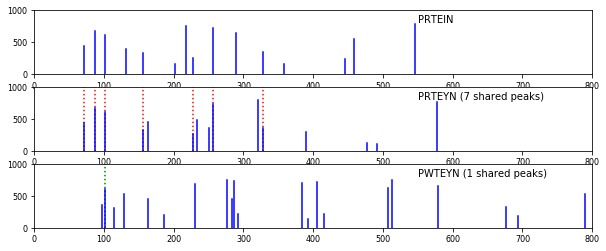

In [3]:
import numpy
import matplotlib
import matplotlib.pyplot as plot
%matplotlib inline
import random

prtein = TheoreticalSpectrum('SMART')
prteyn = TheoreticalSpectrum('TRAYS')
pwteyn = TheoreticalSpectrum('PWTEYN')


height = {}
for peak in prtein:
    if peak not in height:
        height[peak] = random.randint(100,800)
for peak in prteyn:
    if peak not in height:
        height[peak] = random.randint(100,800)
for peak in pwteyn:
    if peak not in height:
        height[peak] = random.randint(100,800)

plot.figure(1, figsize = (10,4))
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('xtick', labelsize=8)
plot.subplot(3, 1, 1)
for peak in prtein:
    plot.plot([peak, peak], [0, height[peak]], 'b')
plot.text(550, 800, "PRTEIN")
plot.xlim((0,800))
plot.ylim((0,1000))

S = 0
plot.subplot(3, 1, 2)
for peak in prteyn:
    if (peak in prtein):
        plot.axvline(x = peak, color = 'r', ls = ':')
        S += 1
    plot.plot([peak, peak], [0, height[peak]], 'b')
plot.text(550, 800, "PRTEYN (%d shared peaks)" % S)
plot.xlim((0,800))
plot.ylim((0,1000))

S = 0
plot.subplot(3, 1, 3)
for peak in pwteyn:
    if (peak in prtein):
        plot.axvline(x = peak, color = 'g', ls = ':')
        S += 1
    plot.plot([peak, peak], [0, height[peak]], 'b')
plot.text(550, 800, "PWTEYN (%d shared peaks)" % S)
plot.xlim((0,800))
result = plot.ylim((0,1000))


<p style="text-align: right; clear: right; margin-right: 200px;">16</p>

# Spectral Convolution to the Rescue!

Difference matrix of spectrums. The elements with multiplicity > 2 are shown in colored boxes. The black outlined boxes enclose elements with multiplicity = 2. The SPC only accounts for the zero entries shown as red circles.

In [22]:
import numpy
import matplotlib
import matplotlib.pyplot as plot
%matplotlib inline
import random
random.seed(1961)

def SpectralConvolution(peptide1, peptide2):
    spectrum1 = TheoreticalSpectrum(peptide1)
    spectrum2 = TheoreticalSpectrum(peptide2)
    N = len(spectrum1)
    M = len(spectrum2)
    repeat = {}

    matplotlib.rc('ytick', labelsize=6)
    matplotlib.rc('xtick', labelsize=6)
    fig = plot.figure(figsize=(6,6))
    ax = plot.gca()
    plot.axis([0, N+1, 0, M+1])
    for i in xrange(len(spectrum1)):
        for j in xrange(len(spectrum2)):
            delta = spectrum2[j]-spectrum1[i]
            if (delta == 0):
                circle = plot.Circle((i+1, j+1), 0.4, color='r')
                ax.add_artist(circle)
            else:
                repeat[delta] = repeat.get(delta,[]) + [(i+1,j+1)]
            plot.text(i+1,j+1,str(delta), fontsize=6, ha="center", va="center")

    for delta, coordList in repeat.iteritems():
        R = len(coordList)
        if (R < 2):
            continue
        if (R == 2):
            cval = 'k'
            for x, y in coordList:
                box = plot.Rectangle((x-0.4,y-0.4), 0.8, 0.8, color=cval, fill=False)
                ax.add_artist(box)
        else:
            cval = '#%02x%02x%02x' % (random.randint(64,255),random.randint(64,255),random.randint(64,255))
            for x, y in coordList:
                box = plot.Rectangle((x-0.4,y-0.4), 0.8, 0.8, color=cval)
                ax.add_artist(box)

    plot.xticks(range(1,N+1), [str(peak) for peak in spectrum1])
    plot.yticks(range(1,M+1), [str(peak) for peak in spectrum2])
    plot.xlabel(peptide1)
    plot.ylabel(peptide2)

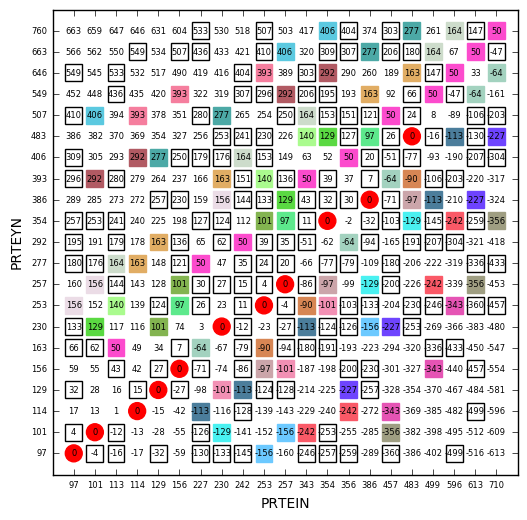

In [23]:

result = SpectralConvolution('PRTEIN', 'PRTEYN')

<p style="text-align: right; clear: right; margin-right: 200px;">17</p>

# Spectral Convolution to the Rescue!

Difference matrix of spectrums. The elements with multiplicity > 2 are shown in colored boxes. The black outlined boxes enclose elements with multiplicity = 2. The SPC only accounts for the zero entries shown as red circles.

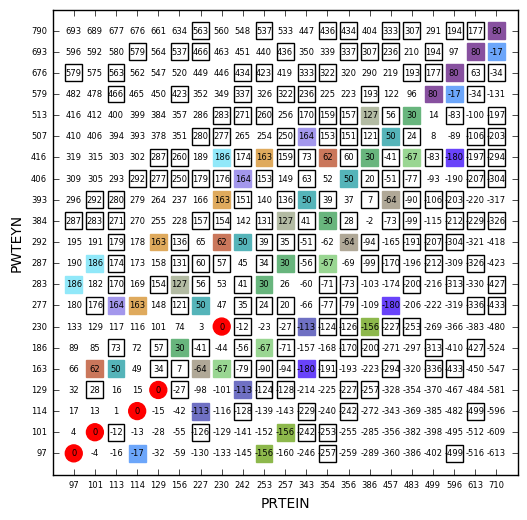

In [17]:
result = SpectralConvolution('PRTEIN', 'PWTEYN')

<p style="text-align: right; clear: right; margin-right: 200px;">18</p>

# Summary

### How do protein structures actually get resolved?

Database searches for protein Mass Specs is generally where most techniques begin. This works paricularly well when it agrees with an already known or very similar protein. However, one can also look for tale-tale fingerprints of peaks from known sub-peptides. For example it is fairly easy to build a library of all 20<sup>6</sup> = 64 million peptides of length 6 and look for eaches 15 associated peaks. Once several hexapeptides ar found you can assemble from there. There are also larger subpeptides 10 to 20 in length that appear frequently.

Another common method is to, rather than brake a protein into every possible subpeptide, use an enzyme to cleave it between particular residue pairs. For example, Trypsin will cleave peptide chains immediately after the amino acids lysine and arginine, except when either is followed by proline. This leads to several large fragments, whose mass can be accurately measured using a Mass Spec. This technique is called Peptide Mass Fingerprinting (PMF).

<p style="text-align: right; clear: right; margin-right: 200px;">19</p>